In [1]:
import sys
from io import BytesIO
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from IPython.display import HTML, display
from matplotlib import cm
from matplotlib.colors import ListedColormap

try:
    from sklearnex import patch_sklearn
except ImportError:
    %pip install scikit-learn-intelex
    from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, ParameterGrid, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from classification_data_loader import *



Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
raw_train_df, test_df, meta_df = load_raw_dataframes()

In [3]:
sampled_train_df = get_sampled_data(raw_train_df)
train_df, validation_df = split_data(sampled_train_df)
del sampled_train_df, raw_train_df

In [4]:
### LBP
LBP_scalar = StandardScaler()

X_train_LBP, X_test_LBP, X_validation_LBP = get_lbp_features(
    train_df, test_df, validation_df
)
X_train_LBP = LBP_scalar.fit_transform(X_train_LBP)
X_test_LBP = LBP_scalar.transform(X_test_LBP)
X_validation_LBP = LBP_scalar.transform(X_validation_LBP)

In [5]:
### HSV Features
Hue_scaler = StandardScaler()
Sat_Scaler = StandardScaler()
Val_Scaler = StandardScaler()

X_train_Hue, X_test_Hue, X_validation_Hue = get_hue_features(
    train_df, test_df, validation_df
)
(
    X_train_Saturation,
    X_test_Saturation,
    X_validation_Saturation,
) = get_saturation_features(train_df, test_df, validation_df)
X_train_Value, X_test_Value, X_validation_Value = get_value_features(
    train_df, test_df, validation_df
)

X_train_Hue = Hue_scaler.fit_transform(X_train_Hue)
X_train_Saturation = Sat_Scaler.fit_transform(X_train_Saturation)
X_train_Value = Val_Scaler.fit_transform(X_train_Value)

X_test_Hue = Hue_scaler.transform(X_test_Hue)
X_test_Saturation = Sat_Scaler.transform(X_test_Saturation)
X_test_Value = Val_Scaler.transform(X_test_Value)

X_validation_Hue = Hue_scaler.transform(X_validation_Hue)
X_validation_Saturation = Sat_Scaler.transform(X_validation_Saturation)
X_validation_Value = Val_Scaler.transform(X_validation_Value)

In [6]:
### Template Fratures
Template_scalar = StandardScaler()

X_train_Template, X_test_Template, X_vaidation_Template = get_template_features(
    train_df, test_df, validation_df
)

X_train_Template = Template_scalar.fit_transform(X_train_Template)
X_test_Template = Template_scalar.transform(X_test_Template)
X_vaidation_Template = Template_scalar.transform(X_vaidation_Template)

In [7]:
### HOG Features
HOG_scaler = StandardScaler()

X_train_HOG, X_test_HOG, X_validation_HOG = get_hog_features(
    train_df, test_df, validation_df
)

X_train_HOG = HOG_scaler.fit_transform(X_train_HOG)
X_test_HOG = HOG_scaler.transform(X_test_HOG)
X_validation_HOG = HOG_scaler.transform(X_validation_HOG)

In [8]:
### VGG16 Features
VGG16_scaler = StandardScaler()

X_train_VGG16, X_test_VGG16, X_validation_VGG16 = get_vgg16_features(
    train_df, test_df, validation_df
)
X_train_VGG16 = VGG16_scaler.fit_transform(X_train_VGG16)
X_test_VGG = VGG16_scaler.transform(X_test_VGG16)
X_validation_VGG = VGG16_scaler.transform(X_validation_VGG16)

In [9]:
### RESNET101 Features
RESNET101_scaler = StandardScaler()

X_train_RESNET101, X_test_RESNET101, X_validation_RESNET101 = get_resnet101_features(
    train_df, test_df, validation_df
)
X_train_RESNET101 = RESNET101_scaler.fit_transform(X_train_RESNET101)
X_test_RESNET101 = RESNET101_scaler.transform(X_test_RESNET101)
X_validation_RESNET101 = RESNET101_scaler.transform(X_validation_RESNET101)

In [10]:
### Construct the Training, Test and Validation Datasets Most Accurate Features


X_train = np.concatenate(
    (X_train_Hue, X_train_HOG, X_train_Template),
    axis=1,
)
X_test = np.concatenate((X_test_Hue, X_test_HOG, X_test_Template), axis=1)
X_validation = np.concatenate(
    (
        X_validation_Hue,
        X_validation_HOG,
        X_vaidation_Template,
    ),
    axis=1,
)

In [11]:
y_train = train_df["ClassId"].to_numpy()
y_test = test_df["ClassId"].to_numpy()
y_validation = validation_df["ClassId"].to_numpy()

In [12]:
# Linear Kernels seem to work very well for our data
joblib_file = Path("most_accurate_svc_classifier_hue_hog_template.joblib")
load_from_file = True
if not joblib_file.exists() or not load_from_file:
    # These parameters wer obtained with GridSearchCV which is currently disabled since it takes over an hour to run
    # We will use a linear kernel, because it seems to work very well for our data
    # We will use a C value of 0.005, because it seems to work very well for our data
    # We will use a one-vs-one decision function, because it seems to work very well for our data
    # We will use a probability function, because it seems to work very well for our data
    # We will use a random state of 42, so we can reproduce the results
    svc_model = make_pipeline(
        # StandardScaler(),
        SVC(
            kernel="linear",
            C=0.005,
            decision_function_shape="ovo",
            probability=True,  # True is our best model according to hyperparameter tuning, but this is excssive on memory
            gamma="scale",
            random_state=42,
        ),
    )
    svc_model.fit(X_train, y_train)
    joblib.dump(svc_model, joblib_file)
else:
    svc_model = joblib.load(joblib_file)
    print("Loaded SVC Model from file")
hyperparameters = svc_model.get_params()
print("Hyperparameters using get_params():")
print(hyperparameters)

Hyperparameters using get_params():
{'memory': None, 'steps': [('svc', SVC(C=0.005, decision_function_shape='ovo', kernel='linear', probability=True,
    random_state=42))], 'verbose': False, 'svc': SVC(C=0.005, decision_function_shape='ovo', kernel='linear', probability=True,
    random_state=42), 'svc__C': 0.005, 'svc__break_ties': False, 'svc__cache_size': 200, 'svc__class_weight': None, 'svc__coef0': 0.0, 'svc__decision_function_shape': 'ovo', 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'linear', 'svc__max_iter': -1, 'svc__probability': True, 'svc__random_state': 42, 'svc__shrinking': True, 'svc__tol': 0.001, 'svc__verbose': False}


In [13]:
##
## Running the Hyperparameter search takes 4 hours. We did this multiple times. Leave it off for now
## This needs over 128GB of RAM to run due to n_jobs=4
##
do_param_search = False
if do_param_search:
    # Previous Runs say linear and 0.1 are the best
    pipeline = make_pipeline(StandardScaler(), SVC(random_state=42))
    param_grid = {
        "svc__kernel": ["linear", "rbf"],
        "svc__C": [0.005, 0.01, 0.05, 0.1],
        "svc__gamma": ["scale", "auto"],
        "svc__decision_function_shape": ["ovo", "ovr"],
        "svc__probability": [True, False],
    }
    grid_search = GridSearchCV(pipeline, param_grid, n_jobs=4, cv=5, scoring="accuracy")
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print("Best Hyperparameters:", grid_search.best_params_)

    joblib.dump(best_model, "best_overall_svc_classifier.joblib")
else:
    print("Skipped Hyperparameter Search")

Skipped Hyperparameter Search


In [14]:
if "best_model" in locals() or "best_model" in globals():
    svc_model = best_model
y_pred = svc_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy on Test Set:", accuracy)


Accuracy on Test Set: 0.936104513064133


<Figure size 1200x1000 with 0 Axes>

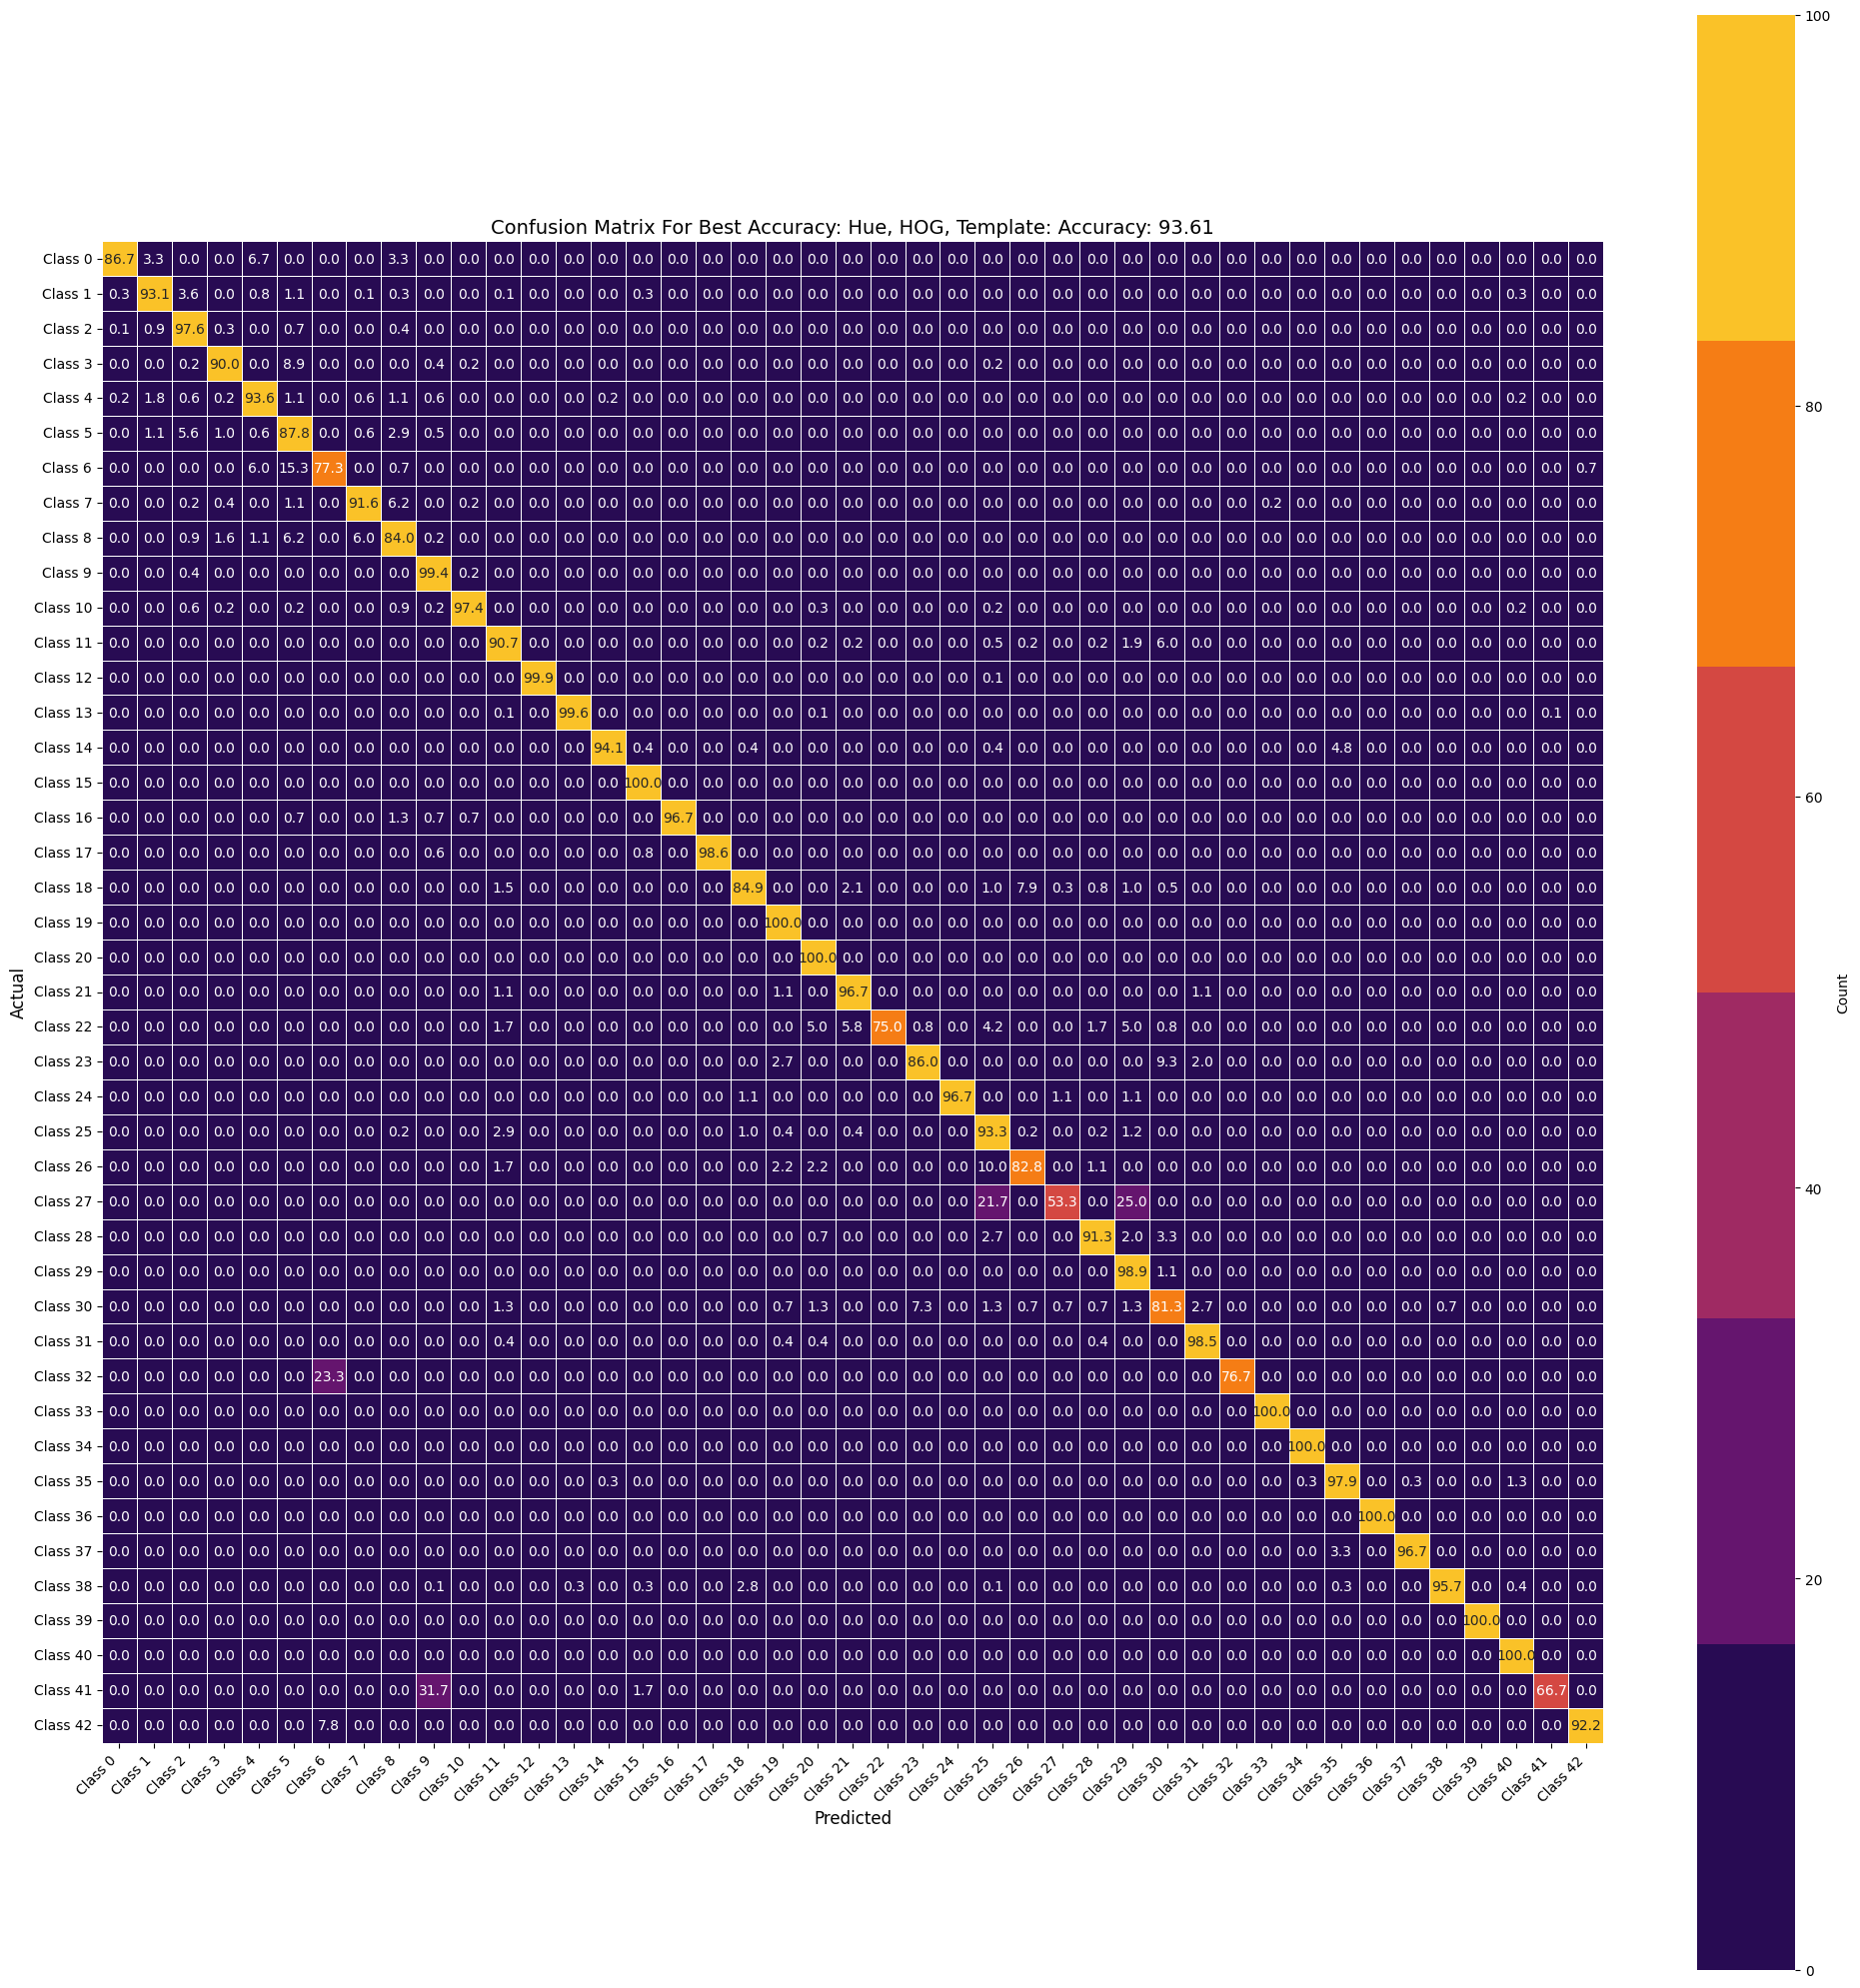

In [15]:
confusion_matrix_result = confusion_matrix(y_test, y_pred)
cm_percent = (
    confusion_matrix_result.astype("float")
    / confusion_matrix_result.sum(axis=1)[:, np.newaxis]
    * 100
)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(12, 10))

class_labels = [f"Class {i}" for i in range(43)]


# Create a color map to represent the count values
color_map = ListedColormap(sns.color_palette("inferno"))
plt.figure(figsize=(20, 20))
sns.heatmap(
    cm_percent,
    annot=True,
    fmt=".1f",
    cmap=color_map,
    linewidths=0.5,
    square=True,
    cbar_kws={"label": "Count"},
    xticklabels=class_labels,
    yticklabels=class_labels,
    annot_kws={"size": 10},
)

# Customize labels and title
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title(
    f"Confusion Matrix For Best Accuracy: Hue, HOG, Template: Accuracy: {accuracy*100:.2f}",
    fontsize=14,
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Adjust layout to prevent cutoff of labels
plt.tight_layout()

# Show the plot
plt.show()

In [16]:
report = classification_report(y_test, y_pred)


def display_classification_report(report):
    report_html = HTML(f"<pre>{report}</pre>")
    display(report_html)


# Display the formatted classification report
display_classification_report(report)

In [17]:
num_classes_confused = 10  # Change this to display more or less classes
flat_cm_percentage = cm_percent.flatten()
# Filter out cases where row index equals column index
non_equal_indices = np.where(
    np.arange(flat_cm_percentage.size) // cm_percent.shape[1]
    != np.arange(flat_cm_percentage.size) % cm_percent.shape[1]
)

# Get the indices of the top 4 most confused items excluding equal indices
top_confused_indices = np.argsort(flat_cm_percentage[non_equal_indices])[::-1][
    :num_classes_confused
]

# Reshape the indices to get corresponding row and column indices
row_indices, col_indices = np.unravel_index(
    non_equal_indices[0][top_confused_indices], cm_percent.shape
)

# Display the top 4 most confused items
top_confused_items = list(
    zip(
        row_indices,
        col_indices,
        flat_cm_percentage[non_equal_indices][top_confused_indices],
    )
)
print(f"\tTop {num_classes_confused} Most Confused Classes:")
print(45 * "-")
for row, col, percentage in top_confused_items:
    print(f"True Class: {row:2d}\tPredicted Class {col:2d}:   {percentage:5.2f}%")

	Top 10 Most Confused Classes:
---------------------------------------------
True Class: 41	Predicted Class  9:   31.67%
True Class: 27	Predicted Class 29:   25.00%
True Class: 32	Predicted Class  6:   23.33%
True Class: 27	Predicted Class 25:   21.67%
True Class:  6	Predicted Class  5:   15.33%
True Class: 26	Predicted Class 25:   10.00%
True Class: 23	Predicted Class 30:    9.33%
True Class:  3	Predicted Class  5:    8.89%
True Class: 18	Predicted Class 26:    7.95%
True Class: 42	Predicted Class  6:    7.78%


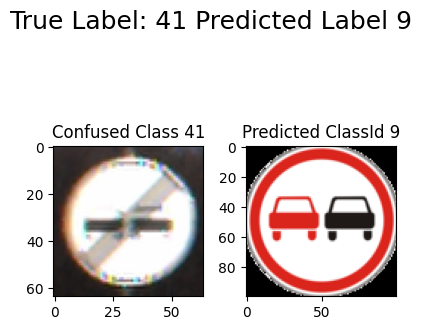

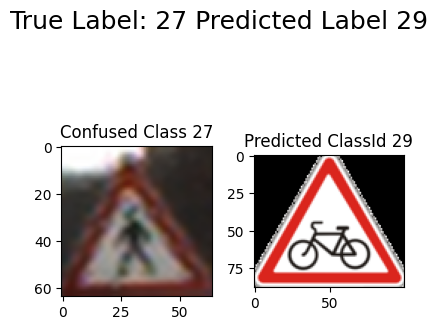

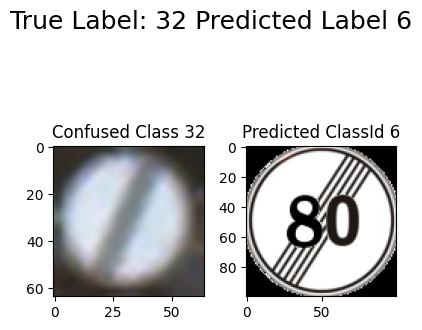

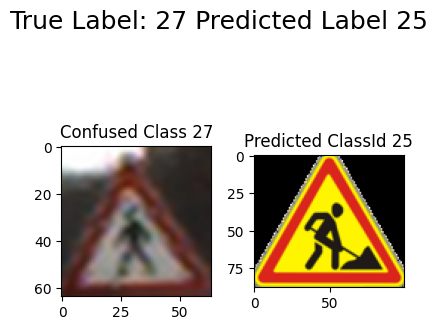

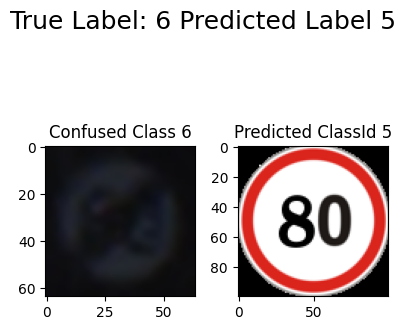

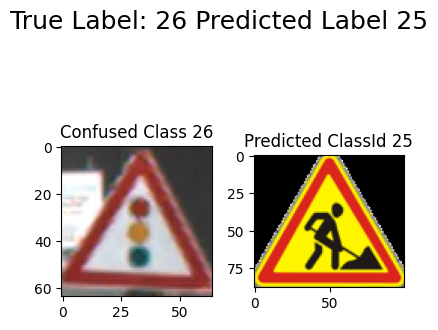

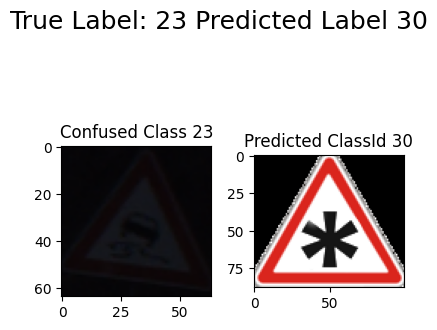

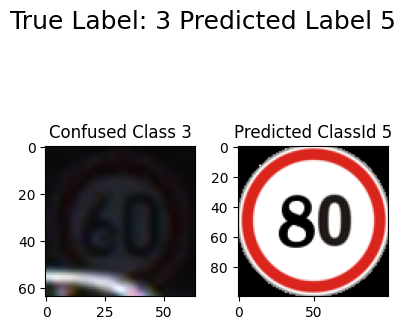

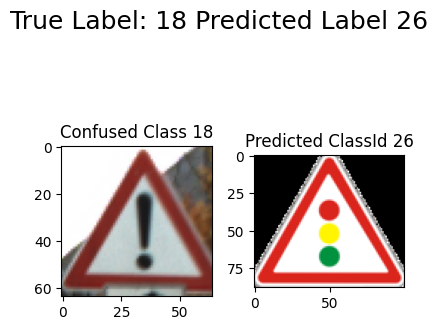

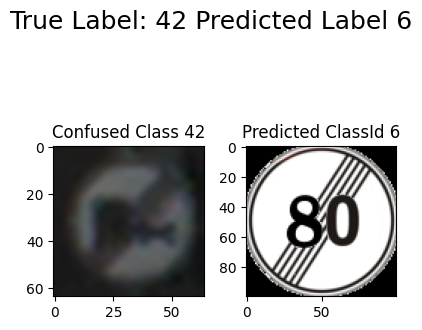

In [18]:
for i, (row, col, _) in enumerate(top_confused_items):
    predicted_image = (
        np.load(BytesIO(meta_df.filter(meta_df["ClassId"] == col)["Meta_Image"][0]))
        * 255.0
    ).astype(np.uint8)
    confused_image = (
        np.load(BytesIO(test_df.filter(test_df["ClassId"] == row)["Image"][0])) * 255.0
    ).astype(np.uint8)
    fig = plt.figure(figsize=(4, 4))
    fig.suptitle(f"True Label: {row} Predicted Label {col}", fontsize=18)
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title("Confused Class " + str(row))
    ax.imshow(confused_image)
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title("Predicted ClassId " + str(col))
    ax.imshow(predicted_image)
    fig.tight_layout()
    plt.show()
    if i + 1 >= num_classes_confused:
        break

In [19]:
### Construct the Training, Test and Validation Datasets Most Efficient Features


X_train = X_train_HOG
X_test = X_test_HOG
X_validation = X_validation_HOG

In [20]:
if svc_model is not None:
    del svc_model
# Linear Kernels seem to work very well for our data
joblib_file = Path("most_efficient_svc_classifier_hog.joblib")
load_from_file = True
if not joblib_file.exists() or not load_from_file:
    # These parameters wer obtained with GridSearchCV which is currently disabled since it takes over an hour to run
    # We will use a linear kernel, because it seems to work very well for our data
    # We will use a C value of 0.005, because it seems to work very well for our data
    # We will use a one-vs-one decision function, because it seems to work very well for our data
    # We will use a probability function, because it seems to work very well for our data
    # We will use a random state of 42, so we can reproduce the results
    svc_model = make_pipeline(
        # StandardScaler(),
        SVC(
            kernel="linear",
            C=0.005,
            decision_function_shape="ovo",
            probability=True,  # True is our best model according to hyperparameter tuning, but this is excssive on memory
            gamma="scale",
            random_state=42,
        ),
    )
    svc_model.fit(X_train, y_train)
    joblib.dump(svc_model, joblib_file)
else:
    svc_model = joblib.load(joblib_file)
    print("Loaded SVC Model from file")
hyperparameters = svc_model.get_params()
print("Hyperparameters using get_params():")
print(hyperparameters)

Hyperparameters using get_params():
{'memory': None, 'steps': [('svc', SVC(C=0.005, decision_function_shape='ovo', kernel='linear', probability=True,
    random_state=42))], 'verbose': False, 'svc': SVC(C=0.005, decision_function_shape='ovo', kernel='linear', probability=True,
    random_state=42), 'svc__C': 0.005, 'svc__break_ties': False, 'svc__cache_size': 200, 'svc__class_weight': None, 'svc__coef0': 0.0, 'svc__decision_function_shape': 'ovo', 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'linear', 'svc__max_iter': -1, 'svc__probability': True, 'svc__random_state': 42, 'svc__shrinking': True, 'svc__tol': 0.001, 'svc__verbose': False}


In [21]:
if "best_model" in locals() or "best_model" in globals():
    svc_model = best_model
y_pred = svc_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy on Test Set:", accuracy)


Accuracy on Test Set: 0.9281076801266825


<Figure size 1200x1000 with 0 Axes>

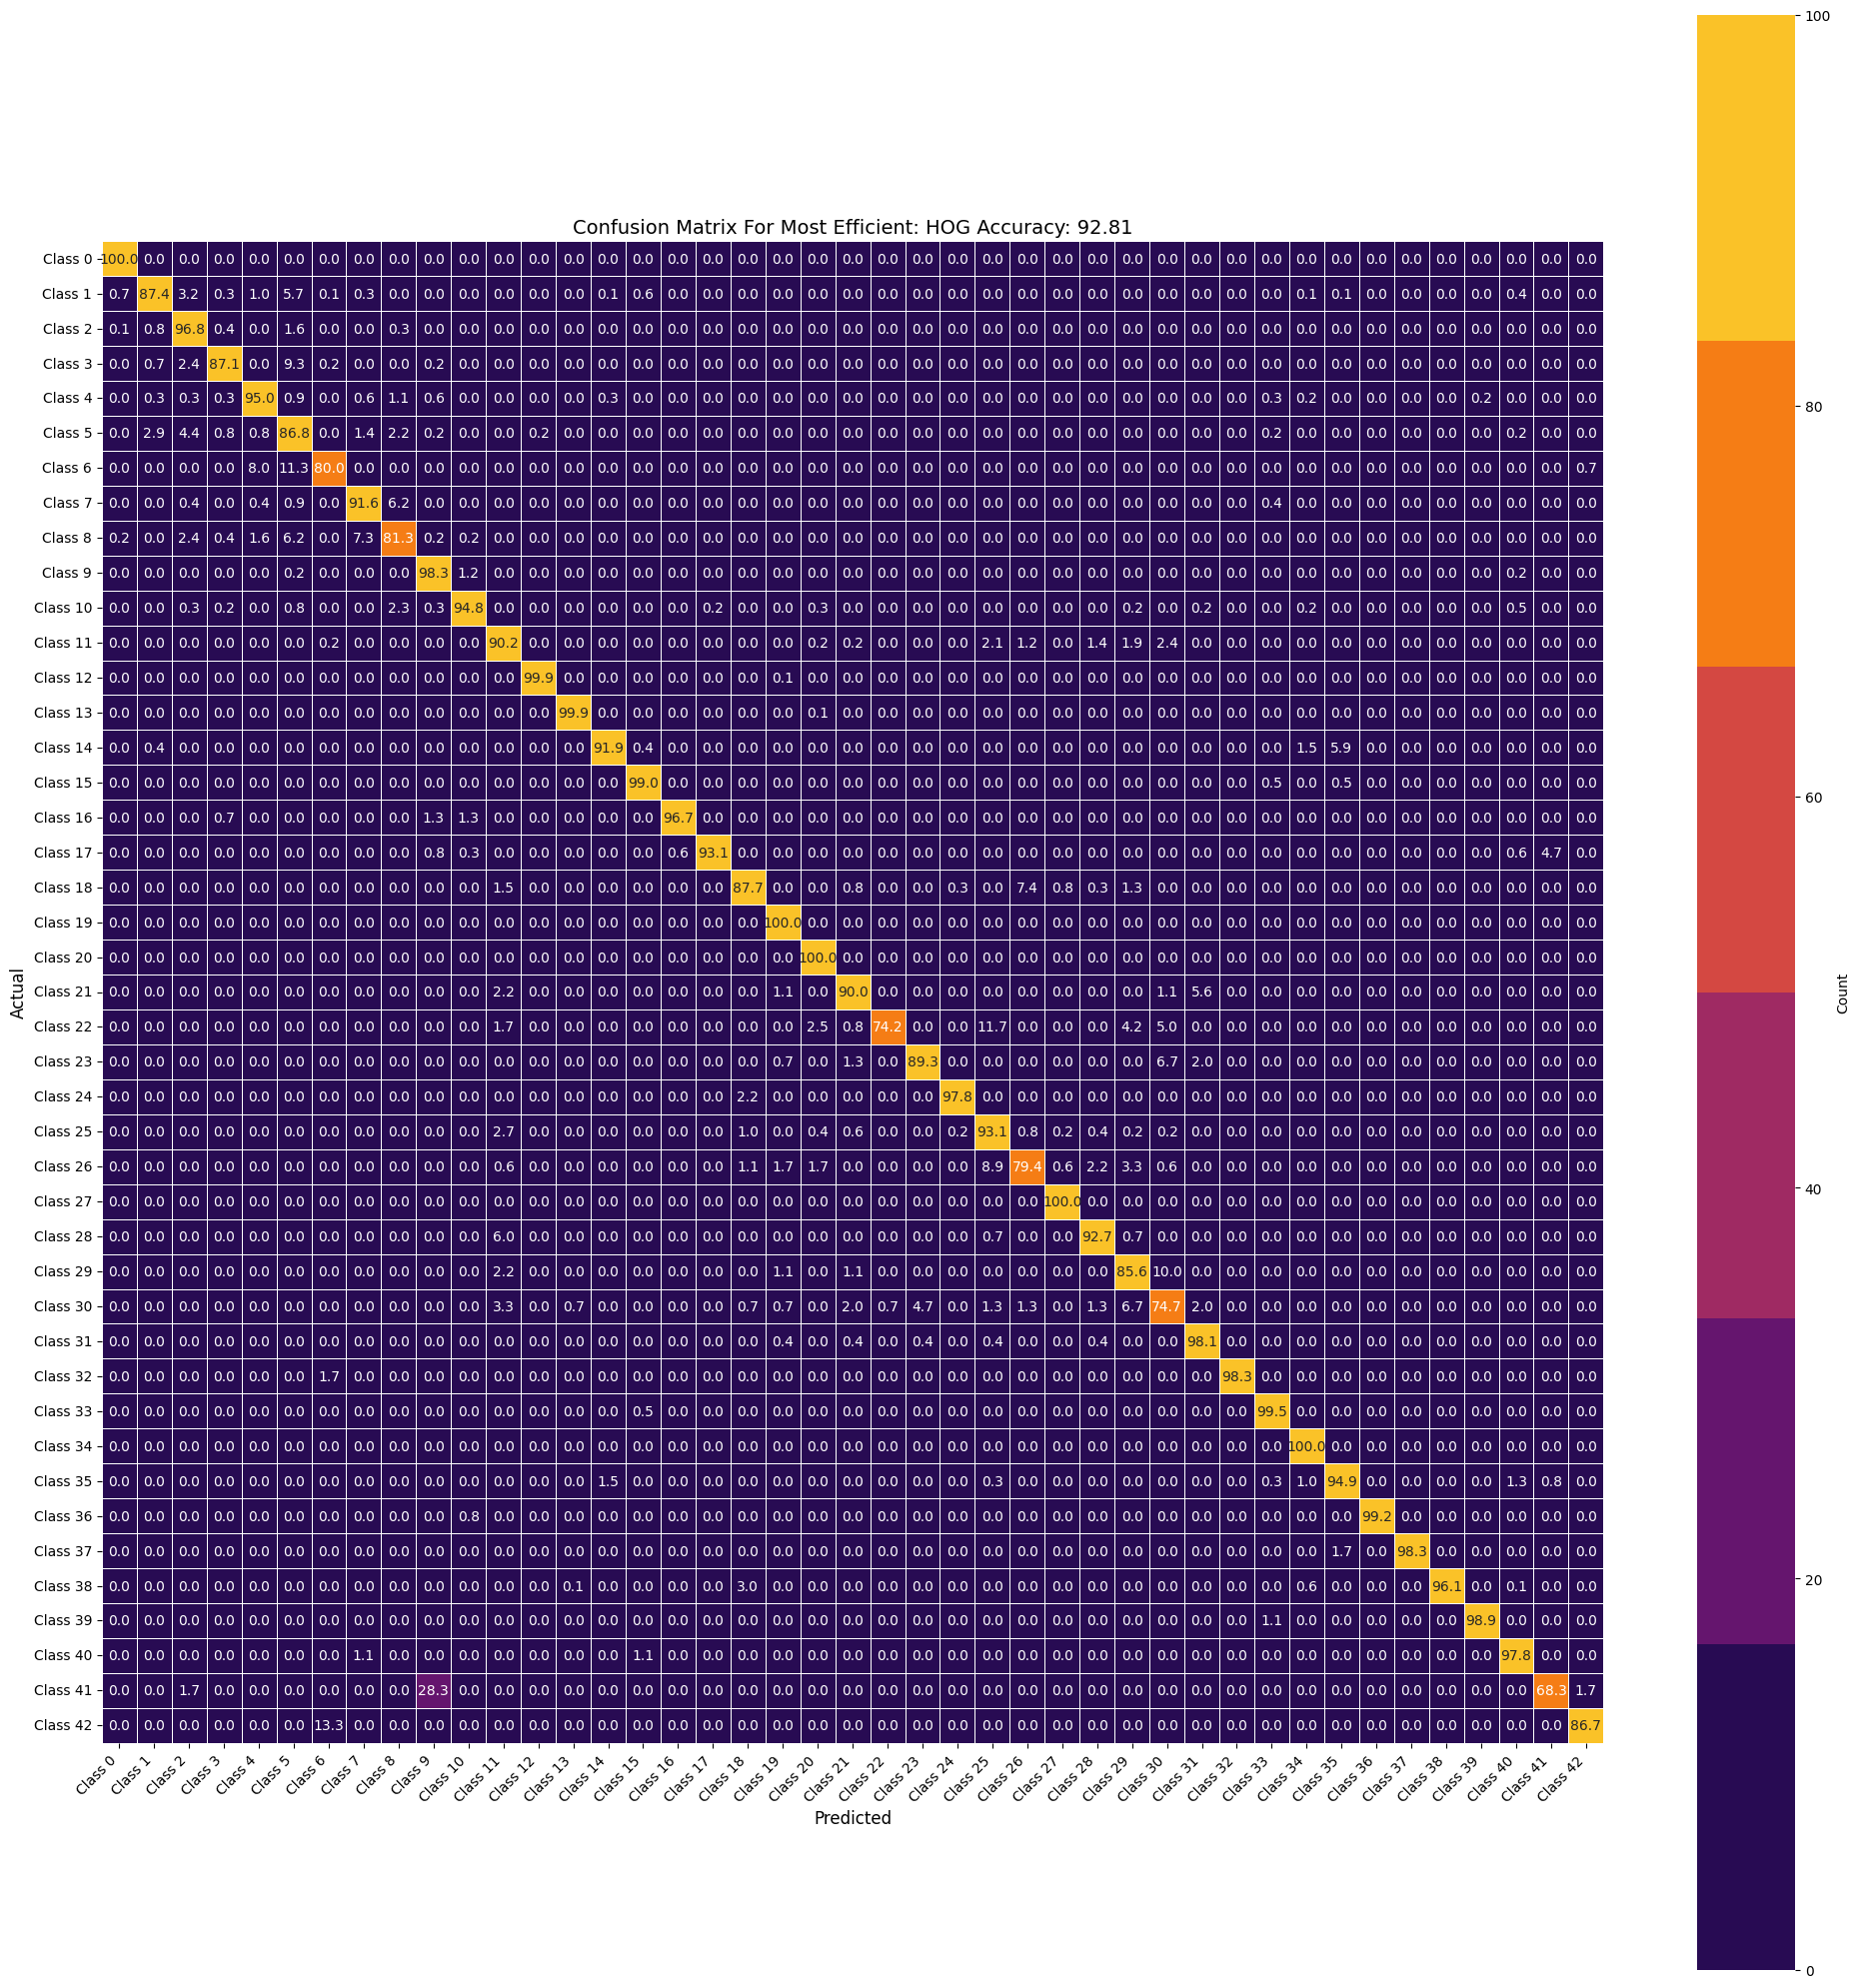

In [22]:
confusion_matrix_result = confusion_matrix(y_test, y_pred)
cm_percent = (
    confusion_matrix_result.astype("float")
    / confusion_matrix_result.sum(axis=1)[:, np.newaxis]
    * 100
)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(12, 10))

class_labels = [f"Class {i}" for i in range(43)]


# Create a color map to represent the count values
color_map = ListedColormap(sns.color_palette("inferno"))
plt.figure(figsize=(20, 20))
sns.heatmap(
    cm_percent,
    annot=True,
    fmt=".1f",
    cmap=color_map,
    linewidths=0.5,
    square=True,
    cbar_kws={"label": "Count"},
    xticklabels=class_labels,
    yticklabels=class_labels,
    annot_kws={"size": 10},
)

# Customize labels and title
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title(
    f"Confusion Matrix For Most Efficient: HOG Accuracy: {accuracy*100:.2f}",
    fontsize=14,
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Adjust layout to prevent cutoff of labels
plt.tight_layout()

# Show the plot
plt.show()

In [23]:
report = classification_report(y_test, y_pred)


def display_classification_report(report):
    report_html = HTML(f"<pre>{report}</pre>")
    display(report_html)


# Display the formatted classification report
display_classification_report(report)

In [24]:
num_classes_confused = 10  # Change this to display more or less classes
flat_cm_percentage = cm_percent.flatten()
# Filter out cases where row index equals column index
non_equal_indices = np.where(
    np.arange(flat_cm_percentage.size) // cm_percent.shape[1]
    != np.arange(flat_cm_percentage.size) % cm_percent.shape[1]
)

# Get the indices of the top 4 most confused items excluding equal indices
top_confused_indices = np.argsort(flat_cm_percentage[non_equal_indices])[::-1][
    :num_classes_confused
]

# Reshape the indices to get corresponding row and column indices
row_indices, col_indices = np.unravel_index(
    non_equal_indices[0][top_confused_indices], cm_percent.shape
)

# Display the top 4 most confused items
top_confused_items = list(
    zip(
        row_indices,
        col_indices,
        flat_cm_percentage[non_equal_indices][top_confused_indices],
    )
)
print(f"\tTop {num_classes_confused} Most Confused Classes:")
print(45 * "-")
for row, col, percentage in top_confused_items:
    print(f"True Class: {row:2d}\tPredicted Class {col:2d}:   {percentage:5.2f}%")

	Top 10 Most Confused Classes:
---------------------------------------------
True Class: 41	Predicted Class  9:   28.33%
True Class: 42	Predicted Class  6:   13.33%
True Class: 22	Predicted Class 25:   11.67%
True Class:  6	Predicted Class  5:   11.33%
True Class: 29	Predicted Class 30:   10.00%
True Class:  3	Predicted Class  5:    9.33%
True Class: 26	Predicted Class 25:    8.89%
True Class:  6	Predicted Class  4:    8.00%
True Class: 18	Predicted Class 26:    7.44%
True Class:  8	Predicted Class  7:    7.33%


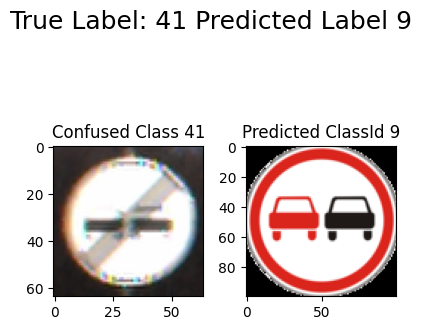

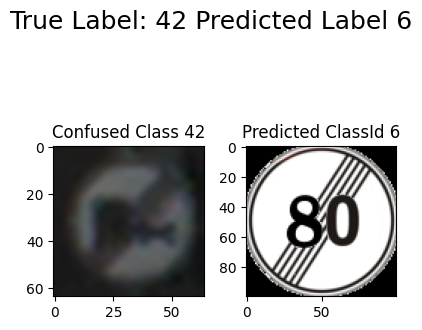

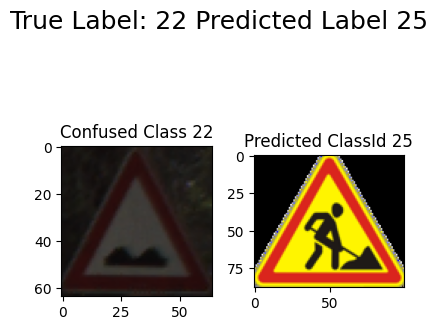

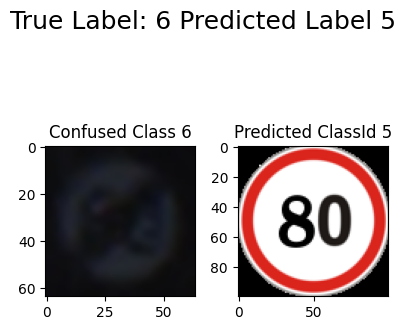

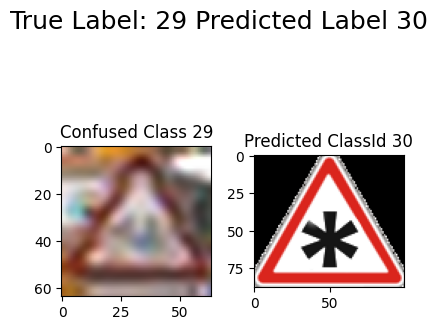

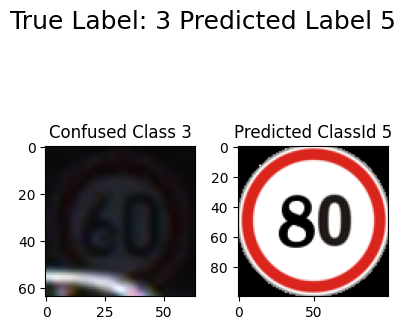

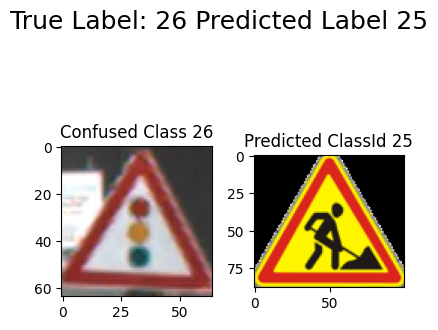

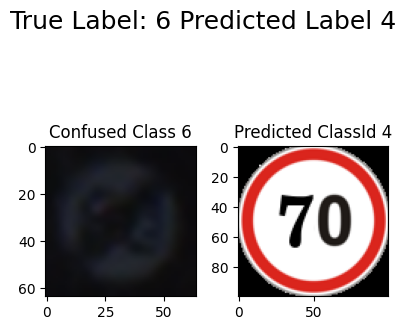

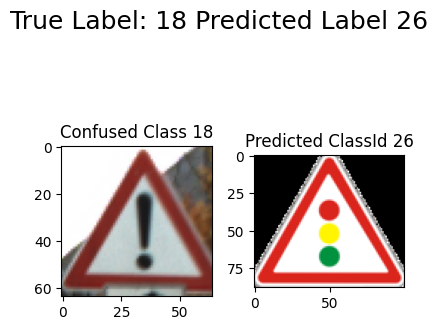

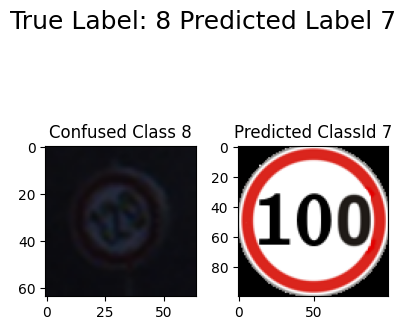

In [25]:
for i, (row, col, _) in enumerate(top_confused_items):
    predicted_image = (
        np.load(BytesIO(meta_df.filter(meta_df["ClassId"] == col)["Meta_Image"][0]))
        * 255.0
    ).astype(np.uint8)
    confused_image = (
        np.load(BytesIO(test_df.filter(test_df["ClassId"] == row)["Image"][0])) * 255.0
    ).astype(np.uint8)
    fig = plt.figure(figsize=(4, 4))
    fig.suptitle(f"True Label: {row} Predicted Label {col}", fontsize=18)
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title("Confused Class " + str(row))
    ax.imshow(confused_image)
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title("Predicted ClassId " + str(col))
    ax.imshow(predicted_image)
    fig.tight_layout()
    plt.show()
    if i + 1 >= num_classes_confused:
        break